In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def load_image_grayscale(path):
    img = Image.open(path).convert('L')  # Convert to grayscale
    img_np = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return img_np

In [23]:
def compute_fft2(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    return fshift

In [24]:
# def generate_circular_masks(shape, grid_size, radius, overlap=0.15):
#     H, W = shape
#     masks = []
#     cx, cy = W // 2, H // 2  # center of frequency domain

#     spacing = 2 * radius * (1 - overlap)

#     x_lin = np.linspace(cx - (grid_size[1] - 1) / 2 * spacing,
#                         cx + (grid_size[1] - 1) / 2 * spacing,
#                         grid_size[1])
#     y_lin = np.linspace(cy - (grid_size[0] - 1) / 2 * spacing,
#                         cy + (grid_size[0] - 1) / 2 * spacing,
#                         grid_size[0])
#     xv, yv = np.meshgrid(x_lin, y_lin)

#     Y, X = np.ogrid[:H, :W]
#     centers = []

#     # Restore original loop order: for each y (row), loop over x (column)
#     for i in range(grid_size[0]):  # rows (y)
#         for j in range(grid_size[1]):  # columns (x)
#             center_x, center_y = int(round(xv[i, j])), int(round(yv[i, j]))
#             mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
#             masks.append(mask.astype(np.float32))
#             centers.append([-(center_y - cy), center_x - cx])

#     centers_px = np.array(centers, dtype=np.int32)[None, :, :]  # (1, N, 2)

#     return masks, centers_px


In [25]:
def generate_circular_masks(shape, grid_size, radius, overlap=0.15):
    H, W = shape
    masks = []
    cx, cy = W // 2, H // 2  # center of frequency domain

    spacing = 2 * radius * (1 - overlap)

    # Frequency domain grid
    x_lin = np.linspace(cx - (grid_size[1] - 1) / 2 * spacing,
                        cx + (grid_size[1] - 1) / 2 * spacing,
                        grid_size[1])
    y_lin = np.linspace(cy - (grid_size[0] - 1) / 2 * spacing,
                        cy + (grid_size[0] - 1) / 2 * spacing,
                        grid_size[0])
    xv, yv = np.meshgrid(x_lin, y_lin)

    # Generate inside-to-outside spiral order
    def center_out_spiral(rows, cols):
        visited = np.zeros((rows, cols), dtype=bool)
        result = []
        # Start from center of grid
        r, c = rows // 2, cols // 2
        if rows % 2 == 0:
            r -= 1
        if cols % 2 == 0:
            c -= 1

        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up
        steps = 1

        result.append((r, c))
        visited[r, c] = True

        while len(result) < rows * cols:
            for d in range(4):
                for _ in range(steps):
                    r += directions[d][0]
                    c += directions[d][1]
                    if 0 <= r < rows and 0 <= c < cols and not visited[r, c]:
                        result.append((r, c))
                        visited[r, c] = True
                    if len(result) == rows * cols:
                        break
                if d % 2 == 1:  # Increase step size every two directions
                    steps += 1
                if len(result) == rows * cols:
                    break
        return result

    spiral_order = center_out_spiral(grid_size[0], grid_size[1])

    Y, X = np.ogrid[:H, :W]
    centers = []

    for i, j in spiral_order:
        center_x, center_y = int(round(xv[i, j])), int(round(yv[i, j]))
        mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
        masks.append(mask.astype(np.float32))
        centers.append([center_x - cx, -(center_y - cy)])

    centers_px = np.array(centers, dtype=np.int32)[None, :, :]  # (1, N, 2)

    return masks, centers_px


In [26]:
def apply_mask_to_fft(fft_image, mask):
    return fft_image * mask

In [27]:
def compute_ifft2(fft_masked):
    f_ishift = np.fft.ifftshift(fft_masked)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

In [28]:
def show_image_and_spectrum(image, fft_image, title_prefix=""):
    magnitude_spectrum = np.log1p(np.abs(fft_image))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'{title_prefix}Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'{title_prefix}FFT Magnitude')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [29]:
def visualize_masks_overlay(fft_image, masks, alpha=0.3):
    base = np.log1p(np.abs(fft_image))
    combined_mask = np.zeros_like(base)

    for mask in masks:
        combined_mask += mask

    plt.figure(figsize=(6, 6))
    plt.imshow(base, cmap='gray')
    plt.imshow(combined_mask, cmap='jet', alpha=alpha)
    plt.title("Circular Mask Grid Overlay")
    plt.axis('off')
    plt.show()

In [30]:
def display_low_res_images(images, grid_size):
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            axs[i, j].imshow(images[idx], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Patch ({i},{j})')
    plt.tight_layout()
    plt.show()


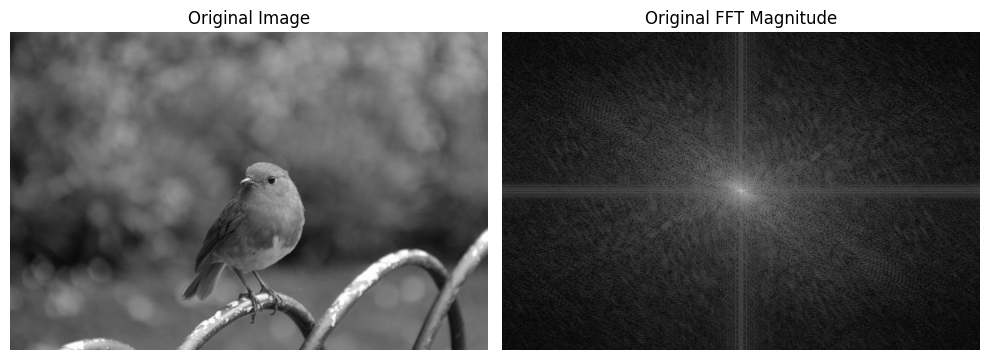

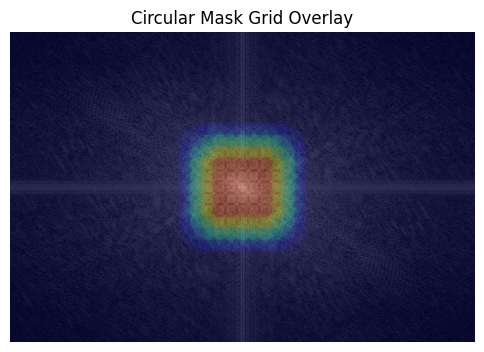

In [31]:
# Load and process image
img = load_image_grayscale(r'C:\Users\beery\OneDrive\桌面\Study\SoSe 2025 Jena\Imip\IMIP-Project\FP_Yen\bird.jped.jpg')
fshift = compute_fft2(img)

# Show original and spectrum
show_image_and_spectrum(img, fshift, title_prefix="Original ")

# Create masks
grid_size = (8, 8)
radius = 38
masks, Ns = generate_circular_masks(img.shape, grid_size, radius, overlap=0.77)

# Visualize masks on spectrum
visualize_masks_overlay(fshift, masks)


In [32]:
# Apply masks and inverse FFT
low_res_images = []
Ns_index = 0
for mask in masks:
    masked_fft = apply_mask_to_fft(fshift, mask)
    low_res = compute_ifft2(masked_fft)
    low_res_images.append(low_res)

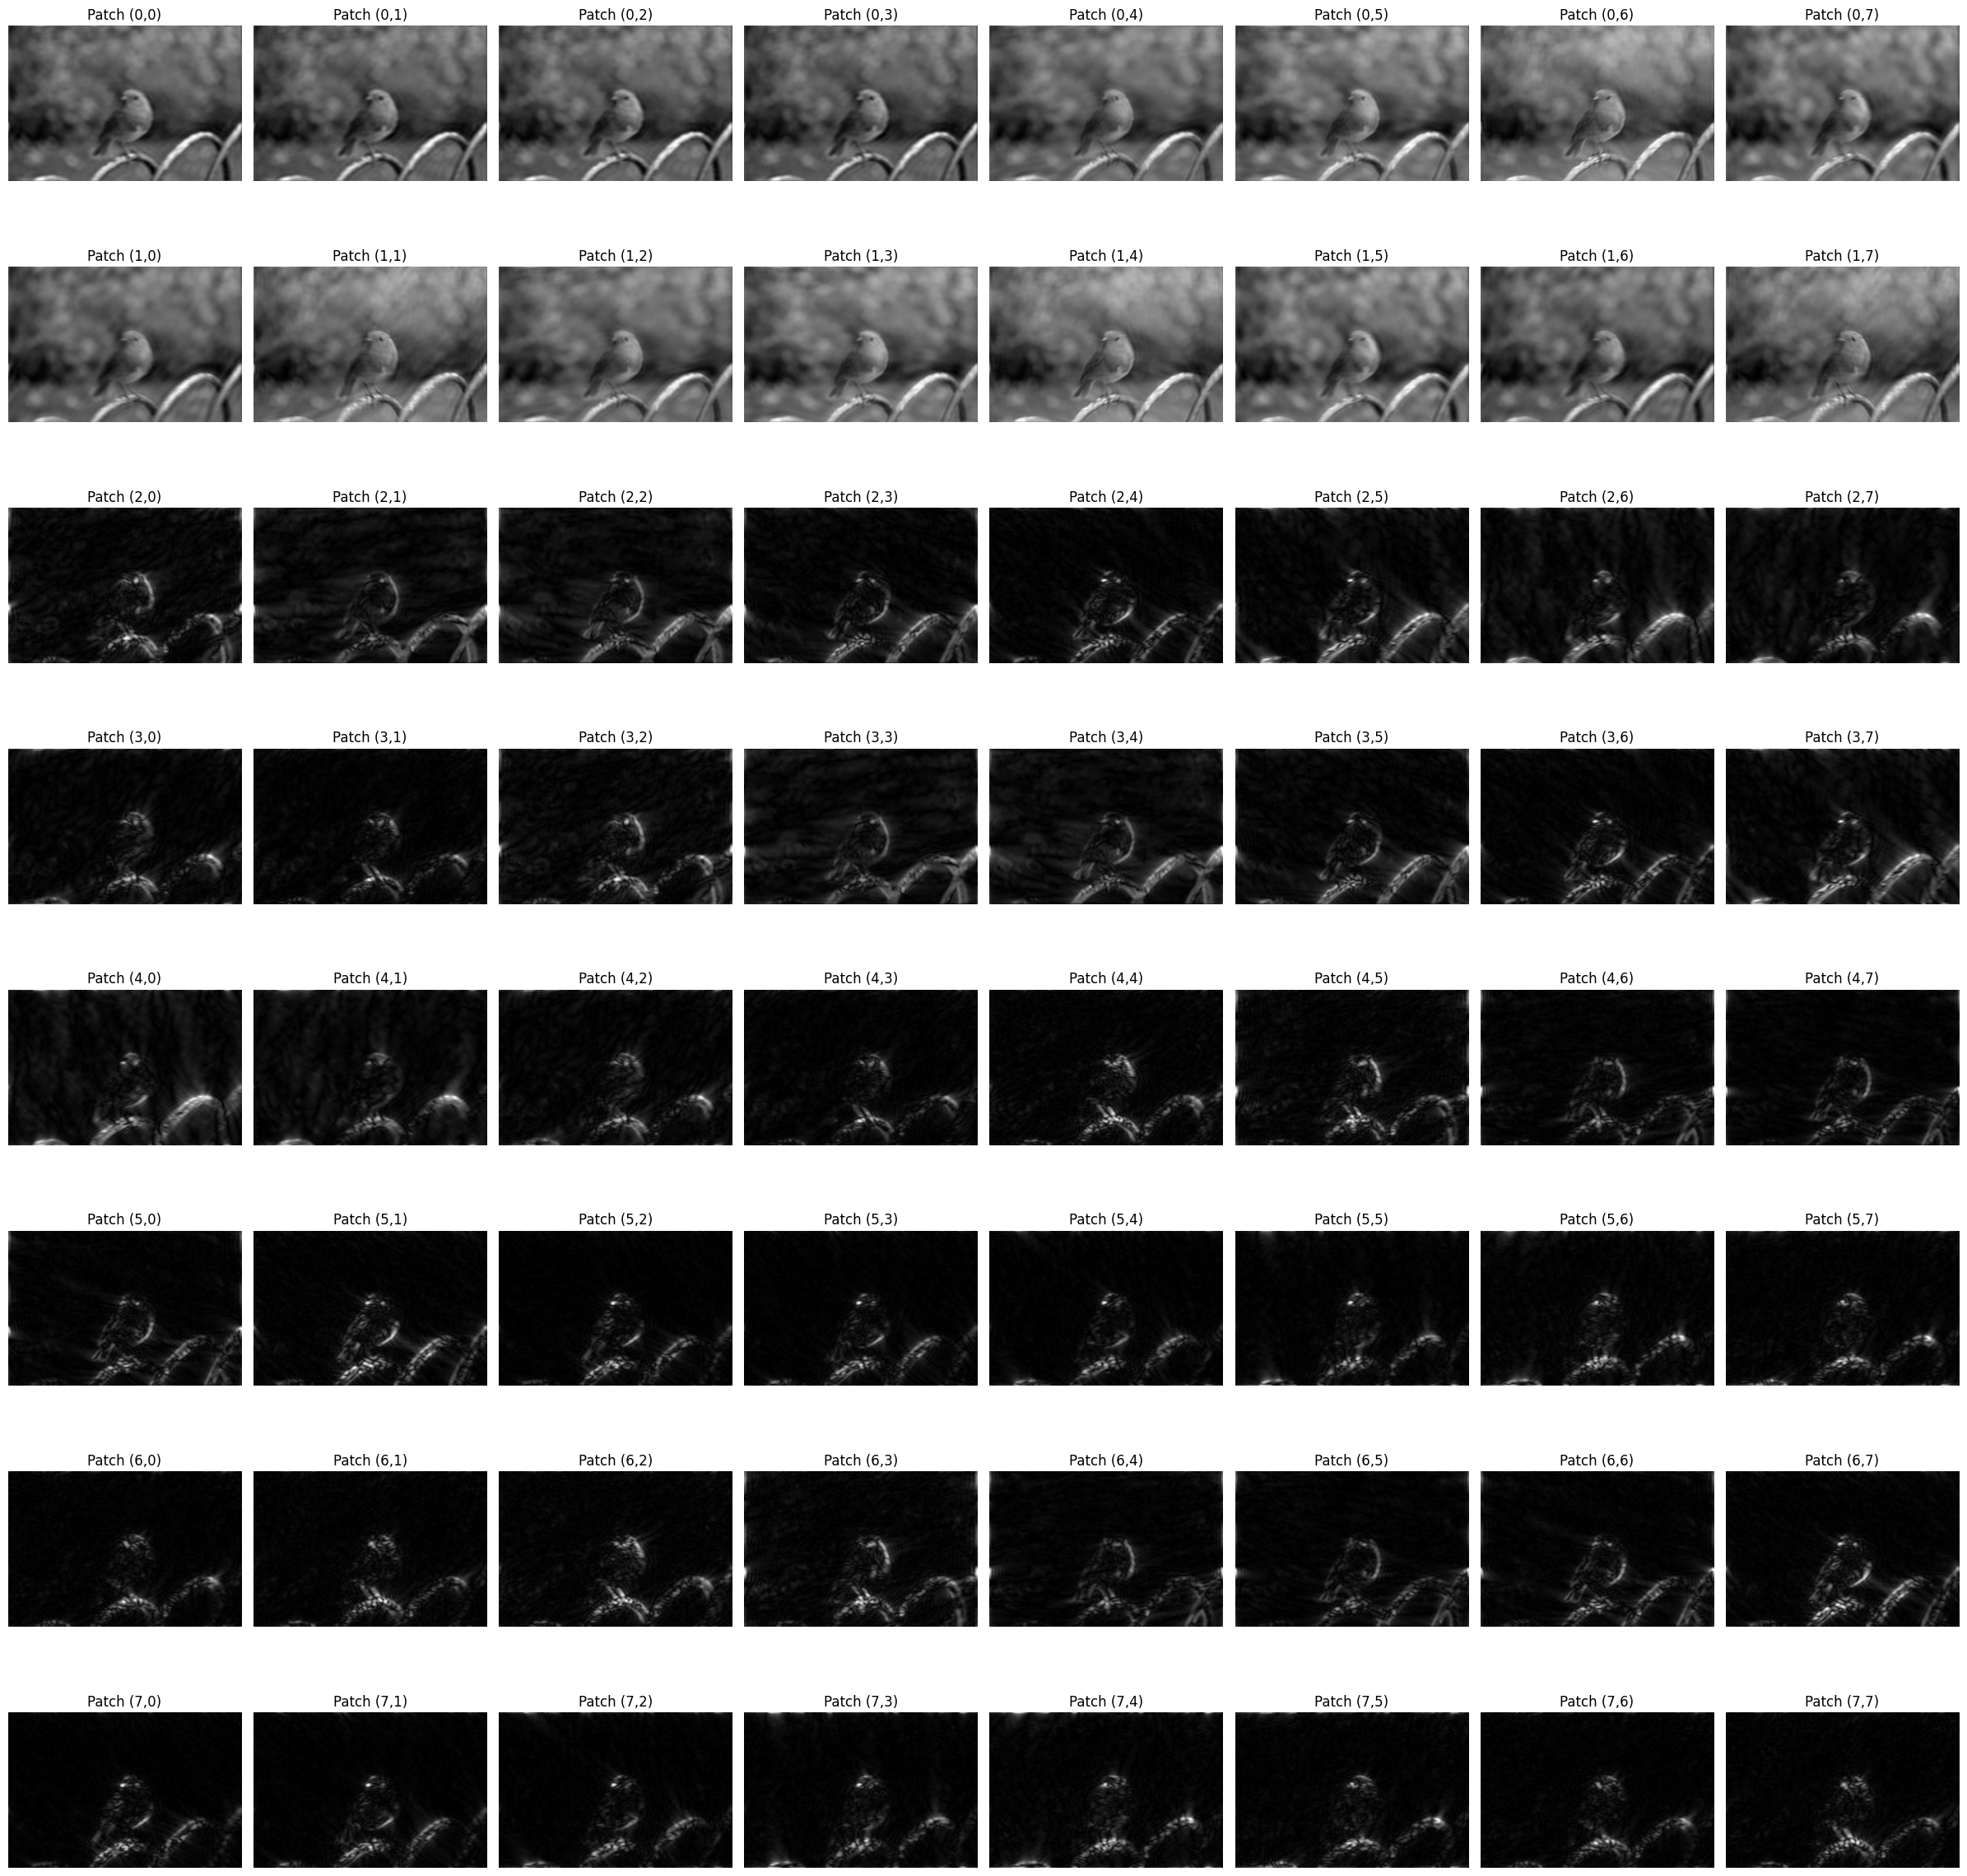

In [33]:
# Display reconstructed images
display_low_res_images(low_res_images, grid_size)

In [34]:
stacked_images = np.stack(low_res_images, axis=-1)
stacked_images.shape

(478, 717, 64)

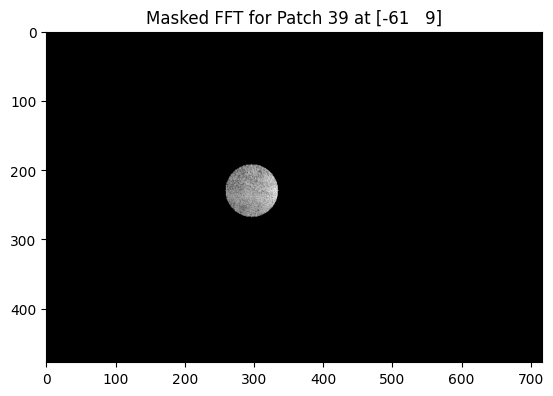

In [35]:
# Sanity check: ensure the Ns and masked_fft match
check_index = 39  # Example index to check
masked_fft = apply_mask_to_fft(fshift, masks[check_index])
plt.imshow(np.log1p(np.abs(masked_fft)), cmap='gray')
plt.title(f'Masked FFT for Patch {check_index} at {Ns[0, check_index]}') # Display the center coordinates for the selected mask
plt.show()

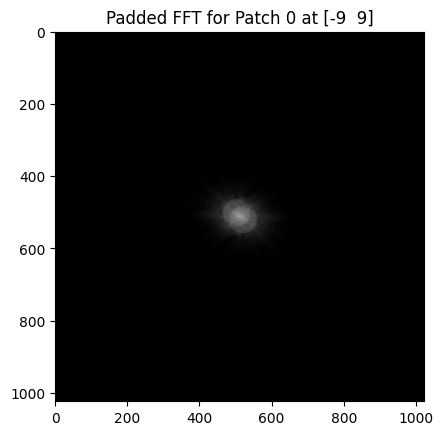

In [66]:
#Debugging: Display the padded FFT for a specific patch
from scipy.fft import fft2, ifft2, fftshift, ifftshift
No=[1024, 1024]
cen0= (((No[0]+1)/2), ((No[1]+1)/2))
# Display the center coordinates for the selected mask  
Np=[478, 717]
pad_y = No[0] - Np[0]
pad_x = No[1] - Np[1]

pad_before_after = [(pad_y // 2, pad_y - pad_y // 2), (pad_x // 2, pad_x - pad_x // 2)]

init_index=0
O0 = np.pad(
    fftshift(fft2(np.sqrt(stacked_images[:, :, init_index]))),
    pad_before_after
)

plt.imshow(np.log1p(np.abs(O0)), cmap='gray')
plt.title(f'Padded FFT for Patch 0 at {Ns[0, init_index, :]}')  # Display the center coordinates for the selected mask
plt.show()

In [ ]:
Ns[0, 1, :]

array([9, 9], dtype=int32)

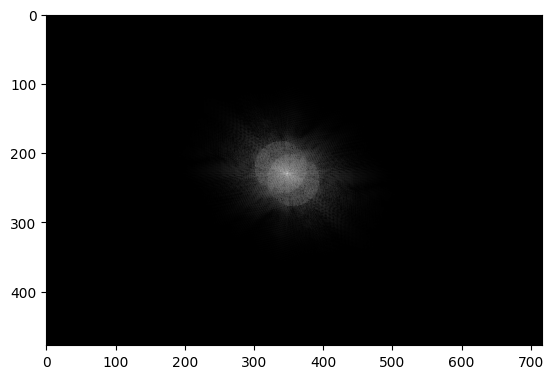

In [ ]:
#Debugging: Display the patch cut by downsamp function
downsamp = lambda x, cen: x[
        cen[0] - Np[0]//2 : cen[0] - Np[0]//2 + Np[0],
        cen[1] - Np[1]//2 : cen[1] - Np[1]//2 + Np[1]
    ]

check_index = 1  # Example index to check
m=check_index
Psi0 = np.zeros((Np[0], Np[1], 1), dtype=complex)
cen = np.zeros((2, 1), dtype=int)
cen[:, 0] = np.array(cen0) +Ns[0, m, :].astype(int)
Psi0[:, :, 0] = downsamp(O0, cen[:, 0])
plt.imshow(np.log1p(np.abs(Psi0[:, :, 0])), cmap='gray')

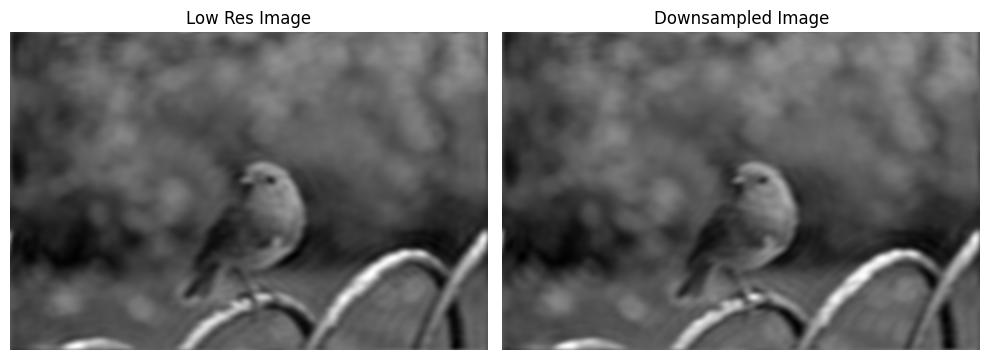

In [97]:
#Debugging: Visualize the fourier transform of the down sampled image
I_est=np.abs(ifft2(ifftshift(Psi0[:, :, 0])))**2
# Debugging: Display the downsampled image and compare with the low_res_images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(low_res_images[1], cmap='gray')
plt.title('Low Res Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(I_est, cmap='gray')
plt.title('Downsampled Image')
plt.axis('off')
plt.tight_layout()
plt.show()


In [106]:
# Calculate the difference between the low resolution image and the downsampled image
np.abs(np.sqrt(np.sum(Psi0[:,:,0] - I_est)**2))

np.float64(65200.956785200746)

In [107]:
%load_ext autoreload
%autoreload 2
import Main_functions
from Main_functions import AlterMin

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


| iter |  rmse    |
--------------------
|  0   | inf |
|  1   | 1.37e+08 |
|  2   | 7.81e+10 |
|  3   | 4.61e+13 |
|  4   | 2.75e+16 |


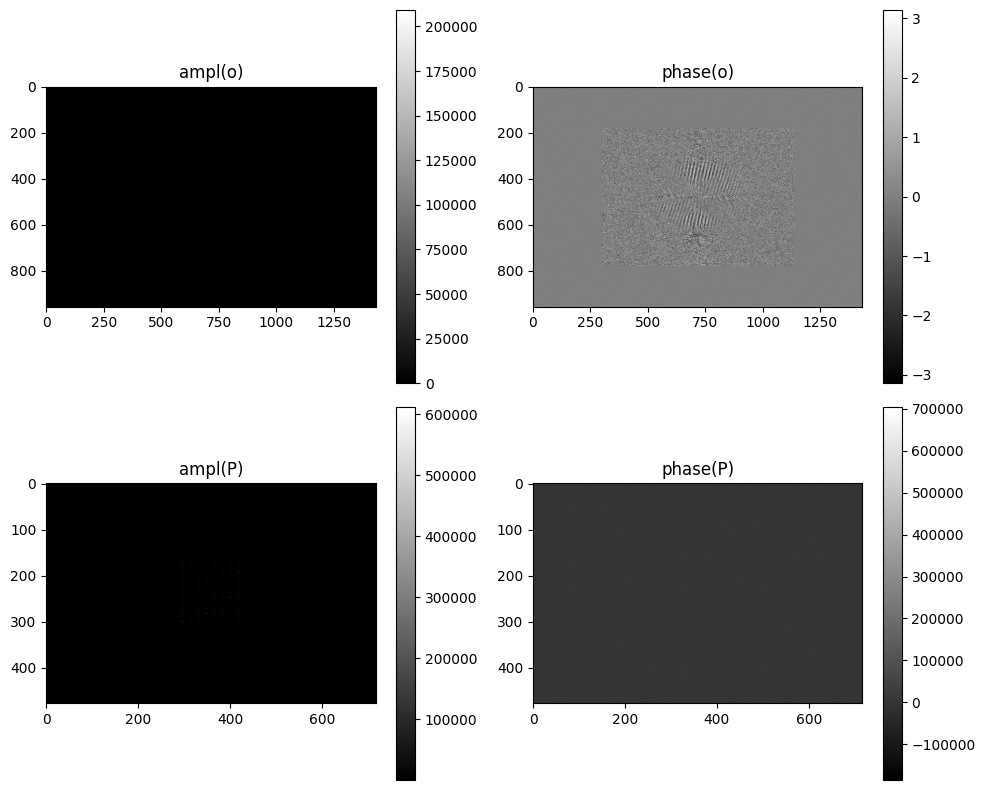

elapsed time: 40 seconds


In [108]:
# Stepsize 0.001
# Alpha Beta are both 10
double_dim=[stacked_images[:,:, 0].shape[0]*2, stacked_images[:,:, 0].shape[1]*2] #Get the doubled dimensions of the image
O, P, err, scale, Ns = AlterMin(stacked_images, double_dim, Ns, {})

Text(0.5, 1.0, 'Optimized Image')

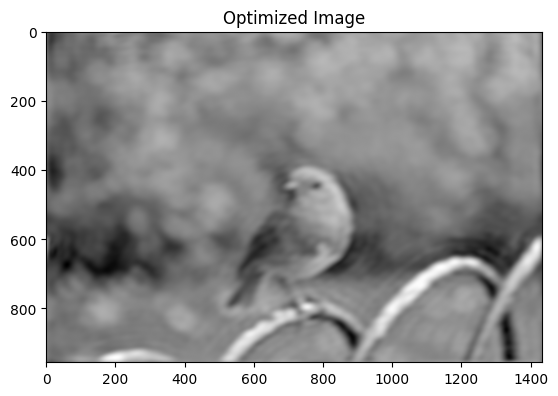

In [109]:
o_image=np.fft.ifft2(O)
plt.imshow(np.abs(o_image), cmap='gray')
# Display the optimized image
plt.title("Optimized Image")